In [1]:
import time
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import CuDNNLSTM,BatchNormalization
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from matplotlib import pyplot
from matplotlib import pyplot as plt
import pickle
import pandas as pd

C:\Users\ndrs\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def loss_plot(history):
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show();
def plot_results_multiple(predicted_data, true_data,x_test_date, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show();    

In [7]:
def load_data(seq_len):
   
   # data=pickle.load(open('processed_data.p', "rb" ))
    data_list=['Barclays-Noida-3.2-Jan', 'Barclays-Noida-3.2-Feb', 'Barclays-Noida-3.2-March','Barclays-Noida-3.2-April']

    for month in range(len(data_list)):
        month_data=pickle.load(open('processed_data/'+data_list[month]+'.p', "rb" ))
        if month==0:
            data=month_data.copy()
        else:
            data=pd.concat([data,month_data])

    seat_data=data.loc[data['seatName']=='B5_9_1_05']
    seat_data=seat_data.sort_values(['Datetime'])
    seat_data=seat_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
    seat_data.set_index('Datetime',inplace=True)
    trial_data=np.array(seat_data['Space'])

    
    #Add rows to columns based on the sequence length
    sequence_length = seq_len + 1
    result = []
    for index in range(len(trial_data) - sequence_length):
        result.append(trial_data[index: index + sequence_length])
    
    # shape is (row)4453, (sequence length) 11
    result = np.array(result)
    
    #Split data
    print('len size',result.shape[0])
    row = round(0.90* result.shape[0])
    train = result[:int(row), :]
    
    #np.random.shuffle(train)
    # X train keeps all the rows but removes last column, col x row(:-1)
    x_train = train[:, :-1]
    # y train keeps the cols with ONLY the values of the missing row (-1)
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,'before reshape')
    #reshape X train and X_test based on the required LSTM shape(samples,Timestep,Features)
        # Samples is the number of rows (can be considered batch size)
        # Timestep is the number of values per row (can be considered values in the batch)
        # features is the number of variables input
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape,'after reshape')
    x_test_date = seat_data.tail(len(x_test)).index
    
    return [x_train, y_train, x_test, y_test,x_test_date]

def build_model(layers):
    model = Sequential()
    #input shape follows the (sequence length,time)
    #input shape (Sequence length(50),num of features(1)), neurons=(seq len)50
    model.add(CuDNNLSTM( input_shape=(layers[1], layers[0]), units=layers[1]))
    model.add(Dense(layers[3]))
    model.add(Activation("sigmoid"))

    start = time.time()
    model.compile(loss="binary_crossentropy", optimizer="adam",metrics=["binary_accuracy",'sparse_categorical_accuracy'])
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    # loop through built prediction batches (test data/pred size)
    for i in range(int(len(data)/prediction_len)):
        #current batch/sequence = test[prediction batch number*prediction length]
        curr_frame = data[i*prediction_len]
        #sample shape = (10,1)
        predicted = []
        # loop through prediction length to build multiple predictions
        for j in range(prediction_len):
            #predict current batch
            # cur_frame[newaxis,:,:] sample shape = (1,10,1)
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            #example result =  [0.011287009]
            #move current frame row by one forward
            curr_frame = curr_frame[1:]
            #insert previous prediction to current frame to predict next sequence
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [14]:
def make_prediction():
        global_start_time = time.time()
        epochs  = 100
        seq_len = 10
        #lstm_dim=50
        lstm_dim2=100
        batch_size=100
        #pred_len=10
        pred_len=seq_len
        print('> Loading data... ')

        X_train, y_train, X_test, y_test,x_test_date = load_data(seq_len)
        print('> Data Loaded. Compiling...')
        
        model = build_model([1, seq_len, lstm_dim2, 1])

        history=model.fit( X_train,y_train,batch_size=batch_size,shuffle=False,epochs=epochs,validation_split=0.20)

        predictions = predict_sequences_multiple(model, X_test, seq_len, pred_len)      
        print('Training duration (s) : ', time.time() - global_start_time)
        show_plot=True
        if show_plot==True:
            loss_plot(history)
            plot_results_multiple(predictions, y_test,x_test_date, seq_len)

> Loading data... 
len size 13341
(12007, 50) (12007,) (1334, 50) (1334,) before reshape
(12007, 50, 1) (12007,) (1334, 50, 1) (1334,) after reshape
> Data Loaded. Compiling...
> Compilation Time :  0.03910398483276367
Train on 9605 samples, validate on 2402 samples
Epoch 1/100
9605/9605 [==============================] - 1s 155us/step - loss: 0.3589 - binary_accuracy: 0.8637 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.2379 - val_binary_accuracy: 0.8976 - val_sparse_categorical_accuracy: 0.8718
Epoch 2/100
9605/9605 [==============================] - 1s 108us/step - loss: 0.2592 - binary_accuracy: 0.8833 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.2178 - val_binary_accuracy: 0.9122 - val_sparse_categorical_accuracy: 0.8718
Epoch 3/100
9605/9605 [==============================] - 1s 108us/step - loss: 0.2479 - binary_accuracy: 0.8946 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.2052 - val_binary_accuracy: 0.9197 - val_sparse_categorical_accuracy: 0.8718
Epoch 4/10

Epoch 34/100
9605/9605 [==============================] - 1s 107us/step - loss: 0.1798 - binary_accuracy: 0.9344 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1750 - val_binary_accuracy: 0.9384 - val_sparse_categorical_accuracy: 0.8718
Epoch 35/100
9605/9605 [==============================] - 1s 107us/step - loss: 0.1799 - binary_accuracy: 0.9343 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1744 - val_binary_accuracy: 0.9376 - val_sparse_categorical_accuracy: 0.8718
Epoch 36/100
9605/9605 [==============================] - 1s 108us/step - loss: 0.1794 - binary_accuracy: 0.9346 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1736 - val_binary_accuracy: 0.9380 - val_sparse_categorical_accuracy: 0.8718
Epoch 37/100
9605/9605 [==============================] - 1s 108us/step - loss: 0.1789 - binary_accuracy: 0.9346 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1739 - val_binary_accuracy: 0.9371 - val_sparse_categorical_accuracy: 0.8718
Epoch 38/100
9605/9605 [========

Epoch 68/100
9605/9605 [==============================] - 1s 121us/step - loss: 0.1684 - binary_accuracy: 0.9381 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1828 - val_binary_accuracy: 0.9309 - val_sparse_categorical_accuracy: 0.8718
Epoch 69/100
9605/9605 [==============================] - 1s 122us/step - loss: 0.1702 - binary_accuracy: 0.9372 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1802 - val_binary_accuracy: 0.9330 - val_sparse_categorical_accuracy: 0.8718
Epoch 70/100
9605/9605 [==============================] - 1s 120us/step - loss: 0.1661 - binary_accuracy: 0.9385 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1829 - val_binary_accuracy: 0.9313 - val_sparse_categorical_accuracy: 0.8718
Epoch 71/100
9605/9605 [==============================] - 1s 123us/step - loss: 0.1667 - binary_accuracy: 0.9385 - sparse_categorical_accuracy: 0.8437 - val_loss: 0.1809 - val_binary_accuracy: 0.9284 - val_sparse_categorical_accuracy: 0.8718
Epoch 72/100
9605/9605 [========

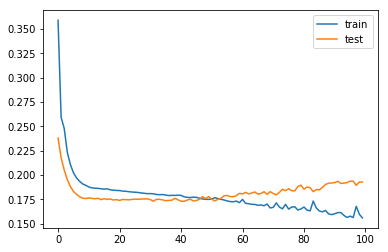

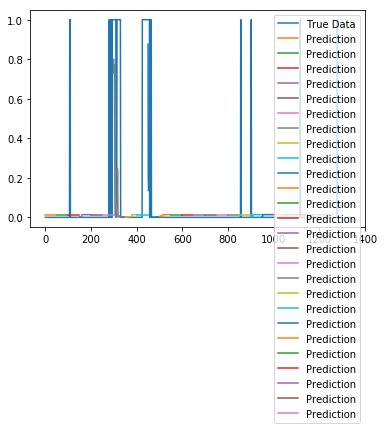

In [15]:
make_prediction()